In [19]:
import os
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,WeightedRandomSampler, random_split, SubsetRandomSampler, Subset
from sklearn.utils.class_weight import compute_class_weight
# Torch Vision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
# Utils
from tqdm import tqdm
import numpy as np
from typing import List
# Train Test Evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score
# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

### Preparing The Models

In [2]:
g_vit_patch = 'google/vit-base-patch16-224'
base_path = './data' # For training Data
base_output_path = './output' # For Storing weights and all
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
NUM_WORKERS = 4

In [13]:
# CNN Model with Explicit Device Handling
class CNNModel(nn.Module):
    def __init__(self, num_classes, device, cnn_model=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)):
        super(CNNModel, self).__init__()
        self.cnn = cnn_model
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_ftrs, num_classes)
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)
        return self.cnn(x)

# ViT Model with Explicit Device Handling
class ViTModel(nn.Module):
    def __init__(self, num_classes, device, vit_model_name=g_vit_patch):
        super(ViTModel, self).__init__()
        self.feature_extractor = ViTImageProcessor.from_pretrained(vit_model_name,do_rescale=False)
        self.model = ViTForImageClassification.from_pretrained(
            vit_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
        )
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)  # Move to the specified device
        # Prepare inputs for ViT model
        feature_input = self.feature_extractor(x, return_tensors="pt").to(self.device)
        logits = self.model(**feature_input).logits
        return logits

# Ensemble Model with Explicit Device Handling
class EnsembleModel(nn.Module):
    def __init__(self, num_classes, cnn_model, vit_model, device):
        super(EnsembleModel, self).__init__()
        self.cnn_model = cnn_model
        self.vit_model = vit_model
        self.fc = nn.Linear(num_classes * 2, num_classes)  # Final linear layer
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)
        
        # Forward through CNN and ViT
        cnn_output = self.cnn_model(x)  # CNN output
        vit_output = self.vit_model(x)  # ViT output
        
        # Combine outputs
        combined_output = torch.cat((cnn_output, vit_output), dim=1)  # Concatenate
        
        # Final linear output
        return self.fc(combined_output)
    
    def eval(self, *args, **kwargs):
        super().eval(*args, **kwargs)  # Call eval() on the parent class
        
        # Call eval() on the underlying models
        self.cnn_model.eval(*args, **kwargs)
        self.vit_model.eval(*args, **kwargs)
        
    def train(self, *args, **kwargs):
        super().train( *args, **kwargs)  # Call train() on the parent class
        
        # Call train() on the underlying models
        self.cnn_model.train( *args, **kwargs)
        self.vit_model.train( *args, **kwargs)

### Data Preparation

In [4]:

def preprocess(base_path: str, device: torch.device):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # Add more transformations if needed
        transforms.ToTensor(),
    ])

    print("Loading Datasets...")
    # Load datasets
    full_dataset = datasets.ImageFolder(
        root=base_path,
        transform=train_transform
    )

    # Calculate the train-test split
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # Split the dataset into train and test sets
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Create DataLoader for train and test sets
    train_loader = DataLoader(train_dataset, num_workers=4, batch_size=80, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, num_workers=4, batch_size=80, shuffle=False, pin_memory=True)

    print("All Done...")
    
    return train_loader, test_loader

In [5]:
# Define the folder where your ECG image data is stored
data_folder = os.path.join(base_path, 'image-data-cardiac-process')

train_loader, test_loader = preprocess(data_folder, device)

Loading Datasets...
All Done...


In [6]:
num_classes = len(train_loader.dataset.dataset.classes)

In [7]:
# Data Quality Checker
def check_sample_data(data_loader, expected_shape, num_samples=5):
    # Get a few samples from the DataLoader
    samples_checked = 0
    for inputs, labels in data_loader:
        if samples_checked >= num_samples:
            break

        # Check dimensions
        if inputs.shape[1:] != expected_shape:
            raise ValueError(f"Unexpected input shape. Expected {expected_shape}, but got {inputs.shape[1:]}")
        
        # Check data type
        if inputs.dtype != torch.float32:
            raise ValueError(f"Unexpected data type. Expected torch.float32, but got {inputs.dtype}")
        
        # Check normalization (values within range)
        if inputs.min() < -1.0 or inputs.max() > 1.0:
            raise ValueError(f"Input data out of expected range. Values should be between -1 and 1.")

        # Check if labels are within the expected range
        if torch.min(labels) < 0 or torch.max(labels) >= len(data_loader.dataset.dataset.classes):
            raise ValueError(f"Unexpected label range. Labels should be between 0 and {len(data_loader.dataset.dataset.classes) - 1}")

        samples_checked += 1

    print(f"Data check completed. {num_samples} samples checked successfully.")


In [8]:
expected_shape = (3, 224, 224)
print("Checking training data...")
check_sample_data(train_loader, expected_shape)

print("Checking test data...")
check_sample_data(test_loader, expected_shape)

Checking training data...
Data check completed. 5 samples checked successfully.
Checking test data...
Data check completed. 5 samples checked successfully.



### Training Ensemble Model

In [9]:
class EpochEvaluator:
    def __init__(self, total_data_count: int, curr_epoch: int, total_epochs: int):
        self.running_loss = 0.0
        self.correct_preds = 0
        self.total_preds = 0
        self.total_data_count = total_data_count
        self.curr_epoch = curr_epoch
        self.total_epochs = total_epochs

    def update_loss(self, loss: float):
        self.running_loss += loss
        return self

    def update_preds(self, correct_preds: int, total_preds: int):
        self.correct_preds += correct_preds
        self.total_preds += total_preds
        return self

    def metrics(self):
        epoch_loss = self.running_loss / self.total_data_count
        epoch_accuracy = self.correct_preds / self.total_preds * 100
        return epoch_loss, epoch_accuracy

    def print_metrics(self):
        epoch_loss, epoch_accuracy = self.metrics()
        print(f'Epoch [{self.curr_epoch + 1}/{self.total_epochs}], '
              f'Training Loss: {epoch_loss:.4f}, '
              f'Training Accuracy: {epoch_accuracy:.2f}%')


class TrainEvaluator:
    def __init__(self):
        self.epochs = []

    def add(self, epoch: EpochEvaluator):
        self.epochs.append(epoch)

    def plot_graph(self):
        epoch_nums = [e.curr_epoch + 1 for e in self.epochs]
        losses = [e.metrics()[0] for e in self.epochs]
        accuracies = [e.metrics()[1] for e in self.epochs]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epoch_nums, losses, 'o-', label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss vs Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epoch_nums, accuracies, 'o-', label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training Accuracy vs Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [10]:
# Define loss function and optimizer on the same device
def train_model(model, train_loader, num_epochs, learning_rate):
    train_eval = TrainEvaluator()
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    total_train = len(train_loader)
    print(f"{num_epochs=} {total_train=}")
    with tqdm(total=num_epochs * total_train) as pbar:
        for epoch in tqdm(range(num_epochs), position=0, leave=True):
            model.train()  # Set model to training mode
            epoch_eval = EpochEvaluator(total_train, epoch, num_epochs)
            # Iterate through training data
            for inputs, labels in tqdm(train_loader,total=total_train, position=0, leave=True):
                inputs,labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()  # Reset gradients
                outputs = model(inputs)  # Forward pass

                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update model parameters
                pbar.update(1)

                _, predicted = outputs.max(1)
                epoch_eval.update_loss(
                    loss.item()
                ).update_preds(
                    (predicted == labels).sum().item(),labels.size(0)
                )
            epoch_eval.print_metrics()
            train_eval.add(epoch_eval)
    return train_eval
            
def test_model(model, test_loader):
    # Evaluate the model to get accuracy, F1 score, and ROC AUC
    model.eval()  # Set to evaluation mode
    # Initialize lists to store predictions and probabilities
    y_true = []
    y_pred = []
    y_proba = []

    total_test = len(test_loader)

    # Collect predictions and ground truth
    with torch.no_grad():        
        # Iterate through test data
        for inputs, labels in tqdm(test_loader, total=total_test):
            inputs,labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            probs = torch.softmax(outputs, dim=1)

            # Extend lists with values from current batch
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())  # Get probabilities for ROC AUC

    # Reshape y_proba into a 2D array
    y_proba = np.array(y_proba)
    return y_true, y_pred, y_proba

In [11]:
# Save the trained models to disk
def save_models(base_path:str, *models):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    # Save models to disk
    for model in models:
        torch.save(model.state_dict(), os.path.join(base_path, model.__class__.__name__))
    print("Models saved successfully!")
    


def load_model_with_weights_if_exists(model, base_path:str):
    model_name = model.__class__.__name__
    model_path = os.path.join(base_path, model_name)
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
    else:
        print('model not found: ', model_path, model_name)
    return model
    
# Load the trained models from disk
def load_models(device:torch.device, base_path:str):
    # Initialize models
    num_classes = 6
    cnn_model = load_model_with_weights_if_exists(CNNModel(num_classes,device))
    vit_model = load_model_with_weights_if_exists(ViTModel(num_classes,device))
    ensemble_model = load_model_with_weights_if_exists(EnsembleModel(num_classes, cnn_model, vit_model, device))
    
    # Move models to the GPU if available
    cnn_model = cnn_model.to(device)
    vit_model = vit_model.to(device)
    ensemble_model = ensemble_model.to(device)

    return cnn_model, vit_model, ensemble_model

In [14]:
# Initialize the models
cnn_model = CNNModel(num_classes,device)
vit_model = ViTModel(num_classes,device, g_vit_patch)
ensemble_model = EnsembleModel(num_classes, cnn_model, vit_model, device)

# Move models to the GPU if available
vit_model = vit_model.to(device)
vit_model = vit_model.to(device)
ensemble_model = ensemble_model.to(device)

model = ensemble_model

eval = train_model(model, train_loader, num_epochs, learning_rate=9e-6)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_epochs=15 total_train=637


100%|█████████▉| 636/637 [10:00<00:00,  1.07it/s]/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  7%|▋         | 1/15 [10:01<2:20:16, 601.21s/it]

Epoch [1/15], Training Loss: 0.3403, Training Accuracy: 89.83%


 13%|█▎        | 2/15 [20:08<2:11:03, 604.88s/it]

Epoch [2/15], Training Loss: 0.2265, Training Accuracy: 92.23%


 20%|██        | 3/15 [30:17<2:01:17, 606.47s/it]

Epoch [3/15], Training Loss: 0.1917, Training Accuracy: 93.24%


 27%|██▋       | 4/15 [40:24<1:51:14, 606.80s/it]

Epoch [4/15], Training Loss: 0.1594, Training Accuracy: 94.43%


 33%|███▎      | 5/15 [50:32<1:41:12, 607.21s/it]

Epoch [5/15], Training Loss: 0.1223, Training Accuracy: 95.79%


 40%|████      | 6/15 [1:00:38<1:31:03, 607.04s/it]

Epoch [6/15], Training Loss: 0.0866, Training Accuracy: 97.23%


 47%|████▋     | 7/15 [1:10:47<1:20:58, 607.37s/it]

Epoch [7/15], Training Loss: 0.0585, Training Accuracy: 98.30%


 53%|█████▎    | 8/15 [1:20:54<1:10:51, 607.36s/it]

Epoch [8/15], Training Loss: 0.0388, Training Accuracy: 98.93%


 60%|██████    | 9/15 [1:31:02<1:00:45, 607.57s/it]

Epoch [9/15], Training Loss: 0.0315, Training Accuracy: 99.13%


 67%|██████▋   | 10/15 [1:41:10<50:38, 607.64s/it] 

Epoch [10/15], Training Loss: 0.0282, Training Accuracy: 99.19%


 73%|███████▎  | 11/15 [1:51:18<40:31, 607.91s/it]

Epoch [11/15], Training Loss: 0.0270, Training Accuracy: 99.19%


 80%|████████  | 12/15 [2:01:27<30:24, 608.06s/it]

Epoch [12/15], Training Loss: 0.0282, Training Accuracy: 99.14%


 87%|████████▋ | 13/15 [2:11:35<20:16, 608.19s/it]

Epoch [13/15], Training Loss: 0.0260, Training Accuracy: 99.22%


 93%|█████████▎| 14/15 [2:21:43<10:08, 608.12s/it]

Epoch [14/15], Training Loss: 0.0228, Training Accuracy: 99.30%


100%|██████████| 9555/9555 [2:31:51<00:00,  1.05it/s]

Epoch [15/15], Training Loss: 0.0271, Training Accuracy: 99.16%


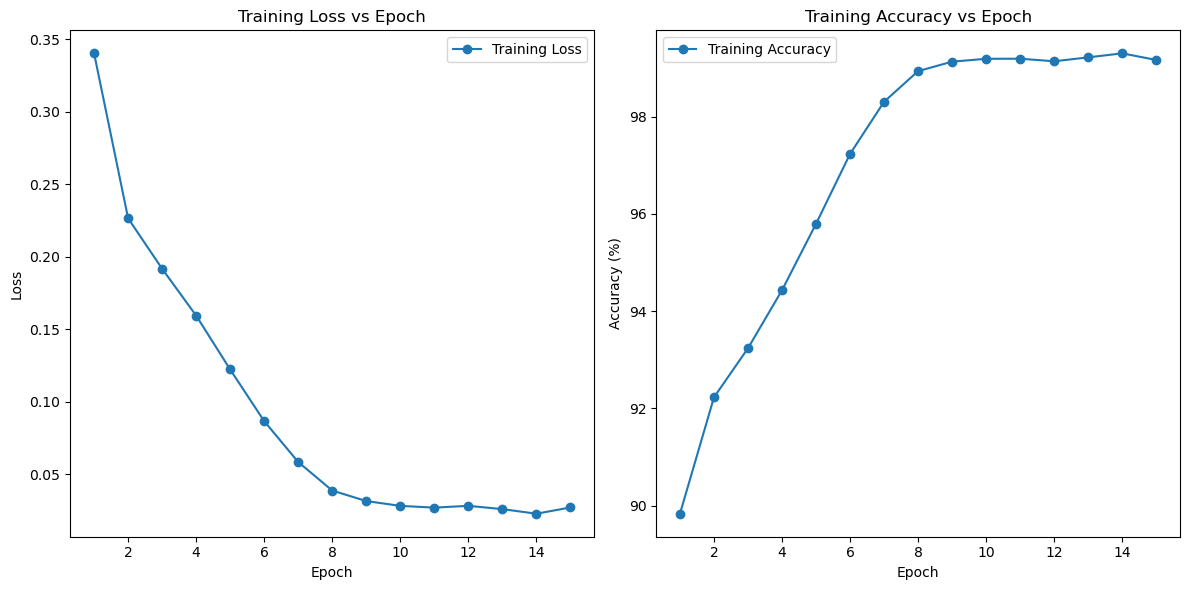

In [15]:
# Plot accuracy and loss for each fold
eval.plot_graph()

In [17]:
# export models
trained_model_path = os.path.join(base_output_path, "model_weights_vit_ensemble_v1_clean_15ep")
save_models(trained_model_path, model)

Models saved successfully!


In [18]:
y_true, y_pred, y_proba = test_model(model, test_loader)

100%|██████████| 160/160 [01:19<00:00,  2.02it/s]


### Evaluation

In [21]:
y_true == y_pred

False

In [24]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate F1 score (weighted to account for class imbalance)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

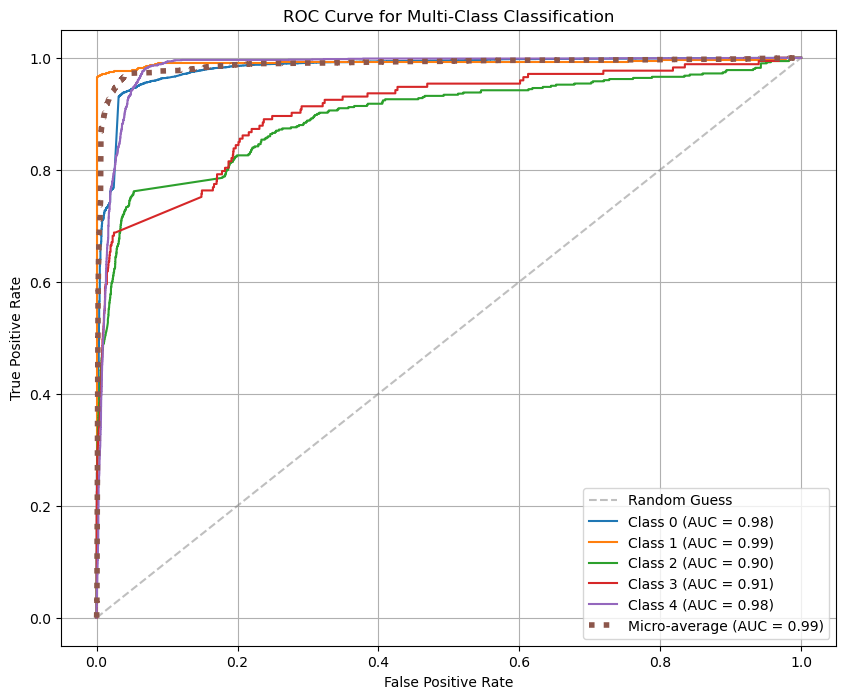

Average ROC AUC: 0.9872119477030907


In [26]:

# Calculate ROC curve and AUC for each class using scikit-learn
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_proba[:, i])
    roc_auc[i] = roc_auc_score((np.array(y_true) == i).astype(int), y_proba[:, i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(np.eye(num_classes)[np.array(y_true)].ravel(), y_proba.ravel())
roc_auc["micro"] = roc_auc_score(np.eye(num_classes)[np.array(y_true)], y_proba, average="micro")

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess', alpha=0.5)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print average ROC AUC
print("Average ROC AUC:", roc_auc["micro"])

Accuracy: 0.9275328145877545
F1 Score: 0.923516555461671
Precision:  0.9252419516401126
recall:  0.9275328145877545


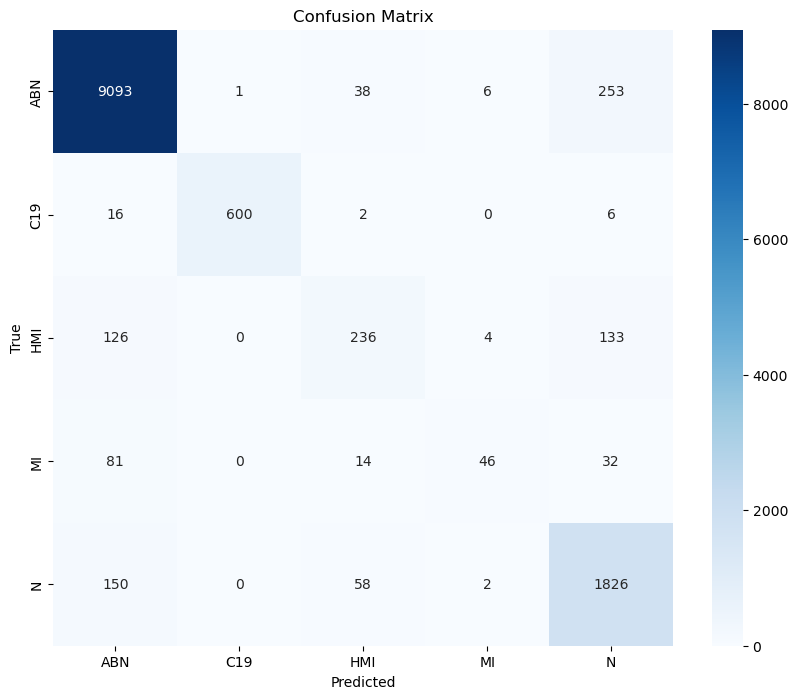

In [25]:
# Print accuracy and F1 score
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision: ",precision)
print("recall: ",recall)
# Confusion matrix for additional visualization
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.dataset.classes, yticklabels=test_loader.dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

